<a href="https://colab.research.google.com/github/AfroGrit/jenga-stock/blob/wk3/Module_03_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install yfinance

# # read files shared via google-drive-link
# # https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

# !pip uninstall gdown -y && pip install gdown
# !gdown -V

In [3]:
!nvidia-smi  # this should display information about available GPUs

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
# %load_ext cudf.pandas

In [68]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [5]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# modelling
from sklearn.metrics import accuracy_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

# for graphs
import matplotlib.pyplot as plt

In [6]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/


Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=7a10113d-8cb1-48f2-8d76-9b7d77fd90a4
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:00<00:00, 151MB/s]


In [7]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )
df_full.info()


<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [8]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]

# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']


CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]

TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV

# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]

MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]

# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']




In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


In [10]:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


In [11]:
df.head().T

,3490,3491,3492,3493,3494
Open,58.6875,56.78125,55.5625,56.09375,54.3125
High,59.3125,58.5625,58.1875,56.9375,56.125
Low,56.0,56.125,54.6875,54.1875,53.65625
Close,58.28125,56.3125,56.90625,55.0,55.71875
Adj Close_x,36.065567,34.847271,35.214706,34.035072,34.479843
...,...,...,...,...,...
growth_btc_usd_7d,NaN,NaN,NaN,NaN,NaN
growth_btc_usd_30d,NaN,NaN,NaN,NaN,NaN
growth_btc_usd_90d,NaN,NaN,NaN,NaN,NaN
growth_btc_usd_365d,NaN,NaN,NaN,NaN,NaN


In [12]:
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')
print("Other features: ", OTHER)
print("number of unique tickers: ", df_full.Ticker.nunique())

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']
Other features:  ['growth_future_5d', 'is_positive_growth_5d_future']
number of unique tickers:  33


In [13]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


### Question 1 (1 point): Dummies on Month and Week-of-Month

**Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable `is_positive_growth_5d_future`?**

You saw in the correlation analysis and modeling that September and October may be important seasonal months. In this task, we'll go futher and try to generate dummies for Month and Week-of-month (starting from 1). For example, the first week of October should be coded similar to this: 'October_w1'.
Once you've generated the new set of variables, find the most correlated (in absolute value) one with `is_positive_growth_5d_future` and round it to 3 digits after the comma.

Suggested path to a solution:
- [[Source](https://stackoverflow.com/questions/25249033/week-of-a-month-pandas)] Use this formula to get the week of month for the datetime variable d: `(d.day-1)//7+1`
- Define a new string variable for all month-week_of_month combinations. Append it to the CATEGORICAL features set. You should have 5 variables treated as CATEGORICAL now: 'Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom'. In the end, you should get 115 dummy features, including 60 (=12*5) week_month_of_week dummies.
- Use [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to generate dummies.
- Use [pandas.DataFrame.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function (also used in [Code Snippet 1]) to get correlations with `is_positive_growth_5d_future`, filter out only variables representing the new dummy set, and sort it by absolute values (you can define a new column "abs_corr" in the dataframe with correlations), and find the highest value (among the new dummies features set).

**NOTE**: new dummies will be used as features in the next tasks, please leave them in the dataset.

In [14]:
def weekinmonth(dt: pd.Timestamp) -> str:
    """
    Calculate the week number within the month for a given date.

    Parameters:
    dt (pd.Timestamp): The date for which to calculate the week number.

    Returns:
    str: A string in the format 'Mon_w_X', where 'Mon' is the abbreviated month name and 'X' is the week number.

    Example:
    >>> dt = pd.Timestamp('2023-05-21')
    >>> weekinmonth(dt) = 'May_w_3'
    """
    return str(dt.strftime('%b') + '_w_' + str(((dt.day - 1) // 7) + 1))

# dates = pd.date_range("2023-12-01", "2024-02-01")
# # print(dates)
# dates.map(weekinmonth)

In [15]:
df['Date'].map(weekinmonth)[:2]

3490    Jan_w_1
3491    Jan_w_1
Name: Date, dtype: object

In [16]:
print(f'categorical vars: {CATEGORICAL}')

# dummy variables are not generated from Date and numeric variables
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

categorical vars: ['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']


In [17]:
df.loc[:,'month_wom'] = df['Date'].map(weekinmonth)

<ipython-input-17-3834a5cea4f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'month_wom'] = df['Date'].map(weekinmonth)


In [18]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')
print(dummy_variables.info())

# get dummies names in a list
print("number of dummy variables: ", len(dummy_variables.keys().to_list()))

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_Sep_w_5
dtypes: int32(115)
memory usage: 81.5 MB
None
number of dummy variables:  115


In [19]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()


In [20]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_Sep_w_5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


In [21]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
df_with_dummies[NUMERICAL+DUMMIES].info()
corr_is_positive_growth_5d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']

# create a dataframe for an easy way to sort
corr_is_positive_growth_5d_future_df = pd.DataFrame(corr_is_positive_growth_5d_future)
corr_is_positive_growth_5d_future_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_Sep_w_5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


,is_positive_growth_5d_future
growth_1d,-0.018940
growth_3d,-0.027915
growth_7d,-0.026683
growth_30d,-0.015110
growth_90d,-0.008799
growth_365d,-0.005779
growth_dax_1d,0.002480
growth_dax_3d,-0.003794
growth_dax_7d,-0.009841
growth_dax_30d,-0.010052


In [22]:
corr_is_positive_growth_5d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']

# create a dataframe for an easy way to sort
corr_is_positive_growth_5d_future_df = pd.DataFrame(corr_is_positive_growth_5d_future)

corr_is_positive_growth_5d_future_df.head()
print(f"\nThe bottom 8 corr:\n {corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').tail(10)}")



The bottom 8 corr:
                               is_positive_growth_5d_future
month_wom_May_w_4                                 0.022264
growth_btc_usd_7d                                 0.023084
month_wom_Oct_w_5                                 0.026023
month_wom_Mar_w_4                                 0.026058
growth_btc_usd_30d                                0.027712
growth_future_5d                                  0.668535
is_positive_growth_5d_future                      1.000000
cdl3starsinsouth                                       NaN
cdlconcealbabyswall                                    NaN
cdlmathold                                             NaN


In [23]:
# add column "abs_corr" in the dataframe with correlations
df_with_dummies.loc[:,'abs_corr'] = corr_is_positive_growth_5d_future.filter(like='month_wom_').abs()

In [24]:
corr_is_positive_growth_5d_future.filter(like='month_wom_').abs().max()

0.034536876505795074

In [25]:
corr_growth_future_5d = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['growth_future_5d']
corr_growth_future_5d_df = pd.DataFrame(corr_growth_future_5d)
print(corr_growth_future_5d_df.sort_values(by='growth_future_5d').head())
print(corr_growth_future_5d_df.sort_values(by='growth_future_5d').tail(10))

                       growth_future_5d
growth_7d                     -0.050680
growth_3d                     -0.049925
growth_brent_oil_365d         -0.041784
roc                           -0.040579
rocr                          -0.040579
                              growth_future_5d
growth_btc_usd_30d                    0.030430
Month_October                         0.030568
growth_btc_usd_3d                     0.032382
natr                                  0.036051
growth_btc_usd_7d                     0.036124
is_positive_growth_5d_future          0.668535
growth_future_5d                      1.000000
cdl3starsinsouth                           NaN
cdlconcealbabyswall                        NaN
cdlmathold                                 NaN


### Question 2 (2 points): Define new "hand" rules on macro and technical indicators variables

**What is the precision score for the best of the NEW predictions (pred3 or pred4), rounded to 3 digits after the comma?**

Let's utilize the knowledge from the visualised tree (clf10) (Code Snippet 5: 1.4.4 Visualisation):

* You're asked to define two new 'hand' rules (leading to 'positive' subtrees):
  - `pred3_manual_gdp_fastd`: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
  - `pred4_manual_gdp_wti_oil`: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

* Extend the Code Snippet 3 (Manual "hand rule" predictions): Calculate and add new rules (pred3 and pred4) to the dataframe.You should notice that one of the predictions doesn't have any positive predictions on TEST dataset (while it has many on TRAIN+VALIDATION).

* Debug: check in the `new_df` and the original dataset/data generation process that we didn't make any mistakes during the data transformation step.

* Explain why this can happen even if there are no errors in the data features.

* As a result, write down the precision score for the remaining predictor (round to three decimal points). E.g. if you have 0.57897, your answer should be 0.579.


In [26]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [27]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [28]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [29]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
df_modelling_q2 = df_with_dummies.copy()

In [30]:
df_modelling_q2.groupby(['split'])['Date'].agg({'min','max','count'})


,min,count,max
split,,,
test,2020-09-14,29829,2024-05-07
train,2000-01-03,123458,2017-01-16
validation,2017-01-17,29388,2020-09-11


In [31]:
df_modelling_q2.head()


,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_Oct_w_3,month_wom_Oct_w_4,month_wom_Oct_w_5,month_wom_Sep_w_1,month_wom_Sep_w_2,month_wom_Sep_w_3,month_wom_Sep_w_4,month_wom_Sep_w_5,abs_corr,split
3490,58.68750,59.3125,56.00000,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,NaN,train
3491,56.78125,58.5625,56.12500,56.31250,34.847271,54119000.0,MSFT,2000,January,1,...,0,0,0,0,0,0,0,0,NaN,train
3492,55.56250,58.1875,54.68750,56.90625,35.214706,64059600.0,MSFT,2000,January,2,...,0,0,0,0,0,0,0,0,NaN,train
3493,56.09375,56.9375,54.18750,55.00000,34.035072,54976600.0,MSFT,2000,January,3,...,0,0,0,0,0,0,0,0,NaN,train
3494,54.31250,56.1250,53.65625,55.71875,34.479843,62013600.0,MSFT,2000,January,4,...,0,0,0,0,0,0,0,0,NaN,train


In [32]:
# features for training
df_modelling_q2[NUMERICAL+DUMMIES].head()


,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,month_wom_Oct_w_1,month_wom_Oct_w_2,month_wom_Oct_w_3,month_wom_Oct_w_4,month_wom_Oct_w_5,month_wom_Sep_w_1,month_wom_Sep_w_2,month_wom_Sep_w_3,month_wom_Sep_w_4,month_wom_Sep_w_5
3490,0.998394,0.988341,0.991494,1.372333,1.222951,2.063053,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0
3491,0.966220,0.957492,0.959020,1.309593,1.190225,1.979132,0.975735,0.960256,1.014543,1.105941,...,0,0,0,0,0,0,0,0,0,0
3492,1.010544,0.974839,0.955405,1.267223,1.220510,1.949679,0.987114,0.934455,0.958669,1.117215,...,0,0,0,0,0,0,0,0,0,0
3493,0.966502,0.943700,0.936170,1.227336,1.192412,1.959911,0.995824,0.959139,0.946984,1.113536,...,0,0,0,0,0,0,0,0,0,0
3494,1.013068,0.989456,0.944886,1.215405,1.203916,2.013552,1.047265,1.029454,0.988256,1.165368,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_modelling_q2[TO_PREDICT].head()


,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0
3491,0.971143,0
3492,0.929709,0
3493,0.980114,0
3494,1.007291,1


In [34]:
# generate the five new columns for the predictions, pred_0 to pred_5

# pred3_manual_gdp_fastd: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
# pred4_manual_gdp_wti_oil: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

conditions = {
    'pred_0': df_modelling_q2['cci'] > 200,
    'pred_1': df_modelling_q2['growth_1d'] > 1,
    'pred_2': (df_modelling_q2['growth_1d'] > 1) & (df_modelling_q2['growth_snp500_1d'] > 1),
    'pred_3': (df_modelling_q2['gdppot_us_yoy'] <= 0.027) & (df_modelling_q2['fastd'] >= 0.251),
    'pred_4': (df_modelling_q2['gdppot_us_yoy'] >= 0.027) & (df_modelling_q2['growth_wti_oil_30d'] <= 1.005),
}

for pred, condition in conditions.items():
    df_modelling_q2[pred] = condition.astype(int)


In [35]:
PREDICTIONS = [k for k in df_modelling_q2.keys() if k.startswith('pred')]
PREDICTIONS

['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4']

In [36]:

"""
Check if the values in the columns 'pred_3', 'pred_4', and 'is_positive_growth_5d_future' are equal for each row.

This code calculates the number of unique values across the specified columns for each row and returns a boolean
Series indicating whether all values in the columns are the same (True) or not (False).

Returns:
    pd.Series: Boolean Series where True indicates all specified columns in the row have the same value.
"""

# Filter the DataFrame for 'test' split and check for uniqueness
df_modelling_q2_test = df_modelling_q2[df_modelling_q2['split'] == 'test']
df_modelling_q2_val = df_modelling_q2[df_modelling_q2['split'] == 'validation']
df_modelling_q2_train = df_modelling_q2[df_modelling_q2['split'] == 'train']




df_modelling_q2_test['is_correct_naive'] = df_modelling_q2_test[['pred_3', 'pred_4', 'is_positive_growth_5d_future']].nunique(axis=1) == 1


<ipython-input-36-1ee77780b3f7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelling_q2_test['is_correct_naive'] = df_modelling_q2_test[['pred_3', 'pred_4', 'is_positive_growth_5d_future']].nunique(axis=1) == 1


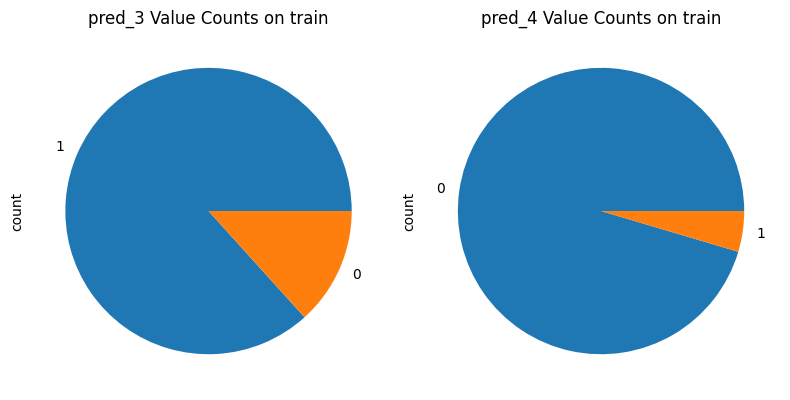

In [37]:

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first pie chart for 'pred_3'
df_modelling_q2_train['pred_3'].value_counts().plot(
    kind='pie',
    ax=axes[0],
    title='pred_3 Value Counts on train'
)

# Plot the second pie chart for 'pred_4'
df_modelling_q2_train['pred_4'].value_counts().plot(
    kind='pie',
    ax=axes[1],
    title='pred_4 Value Counts on train'
)

# Display the plot
plt.tight_layout()
plt.show()


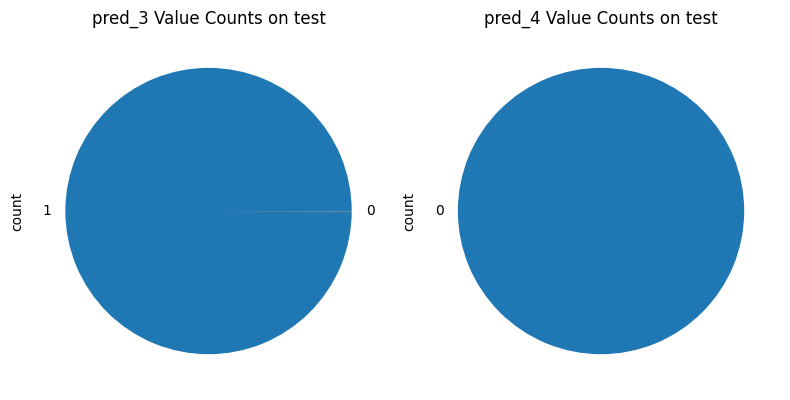

In [38]:

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first pie chart for 'pred_3'
df_modelling_q2_test['pred_3'].value_counts().plot(
    kind='pie',
    ax=axes[0],
    title='pred_3 Value Counts on test'
)

# Plot the second pie chart for 'pred_4'
df_modelling_q2_test['pred_4'].value_counts().plot(
    kind='pie',
    ax=axes[1],
    title='pred_4 Value Counts on test'
)

# Display the plot
plt.tight_layout()
plt.show()


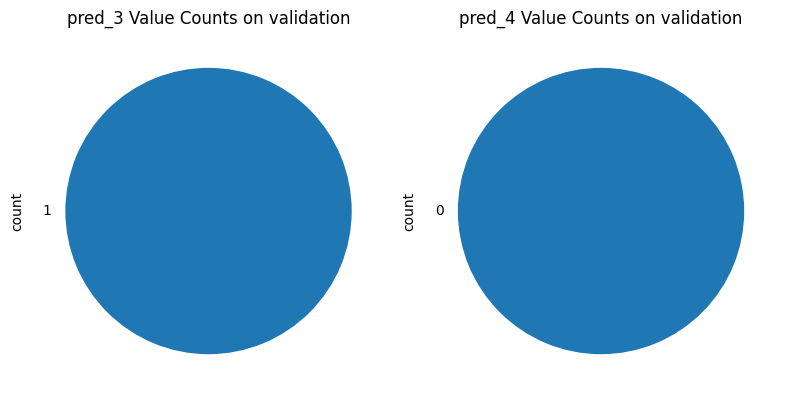

In [39]:

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first pie chart for 'pred_3'
df_modelling_q2_val['pred_3'].value_counts().plot(
    kind='pie',
    ax=axes[0],
    title='pred_3 Value Counts on validation'
)

# Plot the second pie chart for 'pred_4'
df_modelling_q2_val['pred_4'].value_counts().plot(
    kind='pie',
    ax=axes[1],
    title='pred_4 Value Counts on validation'
)

# Display the plot
plt.tight_layout()
plt.show()


In [40]:
y_pred = df_modelling_q2_test[['pred_3', 'pred_4', 'is_positive_growth_5d_future']]['is_positive_growth_5d_future']
X_3 = df_modelling_q2_test[['pred_3', 'pred_4', 'is_positive_growth_5d_future']]['pred_3']
X_4 = df_modelling_q2_test[['pred_3', 'pred_4', 'is_positive_growth_5d_future']]['pred_4']

f'Precision X_pred_3: {precision_score(y_pred, X_3, zero_division=1)}, Precision X_pred_4: {precision_score(y_pred, X_4, zero_division=1)}'

'Precision X_pred_3: 0.5552947488431359, Precision X_pred_4: 1.0'

### Question 3 (1 point): Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)

**What is the total number of records in the TEST dataset when the new prediction pred5_clf_10 is better than all 'hand' rules (pred0..pred4)?**

NOTE: please include `random_state=42` to Decision Tree Classifier init function (line `clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)`) to ensure everyone gets the same results.

Suggested solution:
* Step1: Rewrite the '1.4.3 Inference for a decision tree' piece for the Decision Tree Classifier with max_depth=10 (clf_10), so that you fit the model on TRAIN+VALIDATION sets (unchanged from the lecture), but predict on the whole set X_all (to be able to define a new column 'pred5_clf_10' in the dataframe new_df). Here is the [link](https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe) with explanation. It will solve the problem in 1.4.5 when predictions were made only for Test dataset and couldn't be easily joined with the full dataset.

* Step2: Once you have it, define a new column 'only_pred5_is_correct' similar to 'hand' prediction rules with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.

* Step3: Convert 'only_pred5_is_correct' column from bool to int, and find how many times it is equal to 1 in the TEST set. Write down this as an answer.

ADVANCED: define a function that can be applied to the whole row of predictions ([a few examples of pandas-apply-row-functions](https://sparkbyexamples.com/pandas/pandas-apply-function-to-every-row/)) and can find whether some prediction 'predX' (where X is one of the predictions) is uniquely correct. It should work even if there are 100 predictions available, so that you don't define manually the condition for 'predX'.  


In [41]:
def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

def clean_dataframe(df):
    """
    Cleans the DataFrame by replacing inf and -inf values with NaN and then filling NaN values with 0.

    Parameters:
    df (pd.DataFrame): The DataFrame to clean.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [42]:
df_modelling_q2[['Date', 'pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'is_positive_growth_5d_future', 'split']].head()


,Date,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,split
3490,2000-01-03,0,0,0,0,0,0,train
3491,2000-01-04,0,0,0,0,0,0,train
3492,2000-01-05,0,1,1,0,0,0,train
3493,2000-01-06,0,0,0,0,0,0,train
3494,2000-01-07,0,1,1,0,0,1,train


In [43]:
hand_rules_df = df_modelling_q2[['Date', 'split', 'pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'is_positive_growth_5d_future']]


In [44]:
df_test = df_modelling_q2[df_modelling_q2['split'] == 'test']
df_train_val = df_modelling_q2[df_modelling_q2['split'] != 'test']

df_X = clean_dataframe(df_with_dummies.copy())
df_train_val = clean_dataframe(df_train_val)
df_test = clean_dataframe(df_test)

<ipython-input-41-49c14b29523b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-41-49c14b29523b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [45]:

# fit the model
pred5_clf_10 = DecisionTreeClassifier(max_depth=10, random_state=42)
pred5_clf_10.fit(df_train_val[NUMERICAL+DUMMIES], df_train_val['is_positive_growth_5d_future'])

DecisionTreeClassifier(max_depth=10, random_state=42)

In [46]:
hand_rules_df['pred_5'] = pred5_clf_10.predict(df_X[NUMERICAL+DUMMIES])
hand_rules_df

<ipython-input-46-ed725d4494b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand_rules_df['pred_5'] = pred5_clf_10.predict(df_X[NUMERICAL+DUMMIES])


,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5
3490,2000-01-03,train,0,0,0,0,0,0,1
3491,2000-01-04,train,0,0,0,0,0,0,1
3492,2000-01-05,train,0,1,1,0,0,0,1
3493,2000-01-06,train,0,0,0,0,0,0,1
3494,2000-01-07,train,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
5422,2024-04-30,test,0,0,0,1,0,0,1
5423,2024-05-02,test,0,1,1,1,0,0,1
5424,2024-05-03,test,0,0,0,1,0,0,1
5425,2024-05-06,test,0,0,0,1,0,0,1


In [47]:
hand_rules_df['pred_5'].value_counts()

pred_5
1    151655
0     31020
Name: count, dtype: int64

In [48]:
hand_rules_df['is_positive_growth_5d_future'].value_counts()

is_positive_growth_5d_future
1    99436
0    83239
Name: count, dtype: int64

In [49]:
# Filtering the dataframe where pred_5 matches is_positive_growth_5d_future, on test set
hr_df_test = hand_rules_df[hand_rules_df['split'] == 'test']
# matching pred_5 and is_positive_growth_5d_future
hr_df_test_pred5_match = hr_df_test[hr_df_test['pred_5'] == hr_df_test['is_positive_growth_5d_future']]
hr_df_test_pred5_match

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5
8700,2020-09-17,test,0,0,0,1,0,1,1
8701,2020-09-18,test,0,0,0,1,0,1,1
8702,2020-09-21,test,0,1,0,1,0,1,1
8704,2020-09-23,test,0,0,0,1,0,1,1
8705,2020-09-24,test,0,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...
5412,2024-04-15,test,0,0,0,1,0,1,1
5413,2024-04-16,test,0,0,0,1,0,1,1
5414,2024-04-18,test,0,1,0,1,0,1,1
5415,2024-04-19,test,0,0,0,1,0,1,1


In [50]:
hr_df_test_pred5_match['rematch'] = hr_df_test_pred5_match.loc[:, 'pred_0':'pred_4'].nunique(axis=1) == 1


<ipython-input-50-5c1eec16e228>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_df_test_pred5_match['rematch'] = hr_df_test_pred5_match.loc[:, 'pred_0':'pred_4'].nunique(axis=1) == 1


In [51]:
# print the row where the match is True
hr_df_test_pred5_match[hr_df_test_pred5_match['rematch'] == True]

,Date,split,pred_0,pred_1,pred_2,pred_3,pred_4,is_positive_growth_5d_future,pred_5,rematch
2,2022-05-19,test,0,0,0,0,0,0,0,True
4,2022-05-23,test,0,0,0,0,0,1,1,True


### Question 4: (2 points) Hyperparameter tuning for a Decision Tree

**What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?**

NOTE: please include `random_state=42` to Decision Tree Classifier init function (line `clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)`) to ensure consistency in results.

Follow these steps to find the optimal `max_depth`:
* Iterate through `max_depth` values from 1 to 20.
* Train the Decision Tree Classifier with the current `max_depth` parameter.
* Optionally, visualize how the 'head' of each fitted tree changes with more advanced (=deep) trees. You can use the [`sklearn.tree.plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function, or the compact way  with the `export_text()` functionality ([Stack Overflow example](https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn)):
  ```
  from sklearn.tree import export_text
  tree_rules = export_text(model, feature_names=list(X_train), max_depth=3)
  print(tree_rules)
  ```
* Calculate the precision score (you can use the function [sklearn.metrics.precision_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)) on the TEST dataset for each of the fitted trees. You can also compare it with the precision score on a VALIDATION dataset, which is included to the training phase (to have more data to train on). You should see that the precision score on a VALIDATION set starts to grow with the complexity of a tree (overfit), which isn't seen on the precision score on TEST.
* Identify the optimal `max_depth`, where the  precision score is the highest on the TEST dataset. Record this value as  **best_max_depth** and submit as an answer.
* Make predictions on all records (TRAIN+VALIDATION+TEST) and add the new prediction `pred6_clf_best` to the dataframe `new_df`.

Additionally, compare the precision score of the tuned decision tree with previous predictions. You should observe an improvement (>0.58, or more than 58% precision), indicating that the tuned tree outperforms previous manual "hand" rules and Decision Tree predictions.

ADVANCED: Read more about different aspects of [scikit-learn Decision Trees](https://scikit-learn.org/stable/modules/tree.html). Draw a line of precision/accuracy vs. max_depth and note whether there's a saturation point of precision/accuracy as max_depth increases. In theory, there should be a trade-off between better fitting (=more complex trees) and generalization.

In [52]:
df_with_dummies.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_Oct_w_3,month_wom_Oct_w_4,month_wom_Oct_w_5,month_wom_Sep_w_1,month_wom_Sep_w_2,month_wom_Sep_w_3,month_wom_Sep_w_4,month_wom_Sep_w_5,abs_corr,split
3490,58.68750,59.3125,56.00000,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,NaN,train
3491,56.78125,58.5625,56.12500,56.31250,34.847271,54119000.0,MSFT,2000,January,1,...,0,0,0,0,0,0,0,0,NaN,train
3492,55.56250,58.1875,54.68750,56.90625,35.214706,64059600.0,MSFT,2000,January,2,...,0,0,0,0,0,0,0,0,NaN,train
3493,56.09375,56.9375,54.18750,55.00000,34.035072,54976600.0,MSFT,2000,January,3,...,0,0,0,0,0,0,0,0,NaN,train
3494,54.31250,56.1250,53.65625,55.71875,34.479843,62013600.0,MSFT,2000,January,4,...,0,0,0,0,0,0,0,0,NaN,train


In [53]:
# Define X_train and y_train
X_train = clean_dataframe(df_with_dummies[df_with_dummies['split'] != 'test'][NUMERICAL + DUMMIES])
y_train = clean_dataframe(df_with_dummies.loc[df_with_dummies['split'] != 'test', 'is_positive_growth_5d_future'])

# Define X_test and y_test
X_test = df_with_dummies.loc[df_with_dummies['split'] == 'test', NUMERICAL + DUMMIES]
y_test = df_with_dummies.loc[df_with_dummies['split'] == 'test', 'is_positive_growth_5d_future']

# Define X_all and y_all
X_all = df_with_dummies[NUMERICAL + DUMMIES]
y_all = df_with_dummies['is_positive_growth_5d_future']


In [69]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# # Load dataset and split into train and test sets
# data = load_iris()
# X, y = data.data, data.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5, 10],
    # 'max_features': [None, 'sqrt', 'log2']
    'max_features': ['sqrt']
}

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Initialize Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_clf = grid_search.best_estimator_

# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Evaluate the best model on the test set
y_pred = best_clf.predict(clean_dataframe(X_test))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.47      0.43      0.45     13268
           1       0.57      0.62      0.59     16561

    accuracy                           0.53     29829
   macro avg       0.52      0.52      0.52     29829
weighted avg       0.53      0.53      0.53     29829



In [76]:
import optuna
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt'])

    # Initialize the Decision Tree Classifier with suggested hyperparameters
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Perform cross-validation
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    # Return the mean accuracy score
    return scores.mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=600)

# Print the best parameters found
print(f"Best parameters found: {study.best_params}")

# Train the best model on the full training set
best_clf = DecisionTreeClassifier(
    **study.best_params,
    random_state=42
)
best_clf.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))


[I 2024-05-27 13:54:06,675] A new study created in memory with name: no-name-c4990e2f-fe18-4075-8cd4-95d9de461fad
[I 2024-05-27 13:57:02,916] Trial 0 finished with value: 0.5710583953997881 and parameters: {'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.5710583953997881.
[I 2024-05-27 13:59:56,366] Trial 1 finished with value: 0.5741726131179414 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.5741726131179414.
[I 2024-05-27 14:00:05,294] Trial 2 finished with value: 0.5848566002535296 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5848566002535296.
[I 2024-05-27 14:02:53,982] Trial 3 finished with value: 0.5750886030523054 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 wit

Best parameters found: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
              precision    recall  f1-score   support

           0       0.46      0.41      0.43     13268
           1       0.57      0.62      0.59     16561

    accuracy                           0.53     29829
   macro avg       0.51      0.51      0.51     29829
weighted avg       0.52      0.53      0.52     29829



### [EXPLORATORY] Question 5: What data is missing?

Now that you have some insights from the correlation analysis and the Decision Trees regarding the most influential variables, suggest new indicators you would like to include in the dataset and explain why.

You can also propose something entirely different based on your intuition, but it should be relevant to the shared dataset of the largest Indian, EU, and US stocks. If you choose this approach, please specify the data source as well.

In [102]:
y_train.shape, X_train.shape

((152846,), (152846, 299))

### [EXPLORATORY] Using neural nets?


In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score


# Define the model
model_binary = Sequential([
    Dense(64, activation='relu', input_shape=(time_steps_binary,)),
    Dropout(0.75),
    Dense(32, activation='relu'),
    Dropout(0.73),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_binary.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history_binary = model_binary.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
y_pred_nn_binary = (model_binary.predict(X_train) > 0.5).astype("int32")

# Evaluation
accuracy_nn_binary = accuracy_score(y_train, y_pred_nn_binary)
print(f"Accuracy (Neural Network): {accuracy_nn_binary}")


Epoch 1/10
3822/3822 [==============================] - 11s 3ms/step - loss: 28634374.0000 - accuracy: 0.5165 - val_loss: 3274.2751 - val_accuracy: 0.4988
Epoch 2/10
3822/3822 [==============================] - 10s 3ms/step - loss: 112185.9297 - accuracy: 0.5340 - val_loss: 15.7564 - val_accuracy: 0.5272
Epoch 3/10
3822/3822 [==============================] - 8s 2ms/step - loss: 9054.3223 - accuracy: 0.5409 - val_loss: 6.7935 - val_accuracy: 0.5267
Epoch 4/10
3822/3822 [==============================] - 10s 3ms/step - loss: 8975.0498 - accuracy: 0.5444 - val_loss: 0.6923 - val_accuracy: 0.5268
Epoch 5/10
3822/3822 [==============================] - 10s 3ms/step - loss: 1410.1176 - accuracy: 0.5457 - val_loss: 0.6927 - val_accuracy: 0.5268
Epoch 6/10
3822/3822 [==============================] - 8s 2ms/step - loss: 1181.2217 - accuracy: 0.5460 - val_loss: 0.6927 - val_accuracy: 0.5268
Epoch 7/10
3822/3822 [==============================] - 9s 2ms/step - loss: 408.1722 - accuracy: 0.5459 